In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

# Fungsi Plot Gambar di Jupiter
def plot_images(*imgs, figsize=(30,20), hide_ticks=False):
    f = plt.figure(figsize=figsize)
    width = np.ceil(np.sqrt(len(imgs)))
    height = np.ceil(len(imgs) / width)
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(int(height), int(width), i)
        if hide_ticks:
            ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Fungsi Hamming Distance
def hamming_distance(vector1, vector2):
    # Pastikan kedua vektor memiliki panjang yang sama
    assert len(vector1) == len(vector2), "Panjang vektor harus sama"

    # Hitung Hamming distance
    distance = sum(bit1 != bit2 for bit1, bit2 in zip(vector1, vector2))
    
    return distance

# Jarak 2 titik
def jarak(vector1, vector2):
    return ((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2)**0.5

# Filter fitur
def filter_fitur(kp_pref, des_pref):
    kp_p_f = []
    des_p_f = []
    responses = []
    for idx1, kp in enumerate(kp_pref):
        x, y = kp.pt
        idx2 = -1
        for idx2 in range(len(kp_p_f)):
            if jarak((x,y), kp_p_f[idx2]) < 4: # Adjustable
                if responses[idx2] < kp.response:
                    des_p_f[idx2] = des_pref[idx1,:]
                    kp_p_f[idx2] = (x,y)
                    responses[idx2] = kp.response
                idx2 -= 1
                break
        if idx2 == len(kp_p_f)-1:
            des_p_f.append(des_pref[idx1,:])
            kp_p_f.append((x,y))
            responses.append(kp.response)
    des_p_f = np.array(des_p_f)
    kp_p_f = np.array(kp_p_f)
    return kp_p_f, des_p_f

# Pencocokan fitur
def cocok_fitur(kp_l_f, des_l_f, kp_r_f, des_r_f, dx, dy, overlap):
    pt_mat = []
    for idx1 in range(len(kp_l_f)):
        d_best = float('inf')
        x1,y1 = kp_l_f[idx1]
        if x1 < (1-overlap)*285: #Adjust lebar atau panjang kamera
            continue
        idx = -1
        for idx2 in range(len(kp_r_f)):
            x2,y2 = kp_r_f[idx2]
            if x2 > overlap*285:
                continue
            elif abs(x2-x1)>dx:
                continue
            elif abs(y2-y1)>dy:
                continue
            d = hamming_distance(des_l_f[idx1], des_r_f[idx2])
            if d < d_best:
                d_best = d
                idx = idx2
        if idx == -1:
            continue
        else:
            pt_mat.append((kp_l_f[idx1][0],kp_l_f[idx1][1],kp_r_f[idx][0],kp_r_f[idx][1]))
    pt_mat = np.array(pt_mat)
    return pt_mat

def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2] # standardize to let w*H[2,2] = 1
    return H

def random_point(matches, r, k=4):
    point = np.array([])
    while(True):
        idx = random.sample(range(len(matches)), 1)
        sample = matches[idx]
        j=0
        if len(point)==0:
            point = np.array(sample)
        else:
            for i in range(len(point)):
                x1,y1,x2,y2 = point[i]
                x3,y3,x4,y4 = sample[0]
                if jarak((x1,y1),(x3,y3)) > r:
                    j+=1
                if j == len(point):
                    point = np.append(point, sample, axis=0)
        if len(point) == k:
            break
    return np.array(point)

def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors

def ransac(matches, radius, threshold, iters):
    num_best_inliers = 0
    
    for i in range(iters):
        points = random_point(matches, radius)
        H = homography(points)
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            # best_H = H.copy()
           
    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers


inliers/matches: 151/492
1: 0.05196951536316146
inliers/matches: 120/454
2: 0.05492889557754362
inliers/matches: 43/477
3: 9.401748791498893
inliers/matches: 56/477
3: 4.896350834983351
inliers/matches: 80/477
3: 0.08579964539539939
inliers/matches: 100/476
4: 0.06289965267216563
inliers/matches: 96/487
5: 19.930193073288514
inliers/matches: 101/487
5: 1.416487812827592
inliers/matches: 74/501
6: 55.92058535828868
inliers/matches: 89/501
6: 0.04730386415689309
inliers/matches: 82/505
7: 1.127844734219912
inliers/matches: 45/509
8: 17.1415769179342
inliers/matches: 60/509
8: 0.040587775416569064
inliers/matches: 22/464
9: 215.15725175752976
inliers/matches: 35/464
9: 23.509150033796782
inliers/matches: 22/464
9: 23.509150033796782
inliers/matches: 32/464
9: 3.7791976971904373
inliers/matches: 28/464
9: 3.7791976971904373
inliers/matches: 32/464
9: 3.7791976971904373
inliers/matches: 31/464
9: 3.7791976971904373
inliers/matches: 26/464
9: 3.7791976971904373
inliers/matches: 30/464
9: 3.7

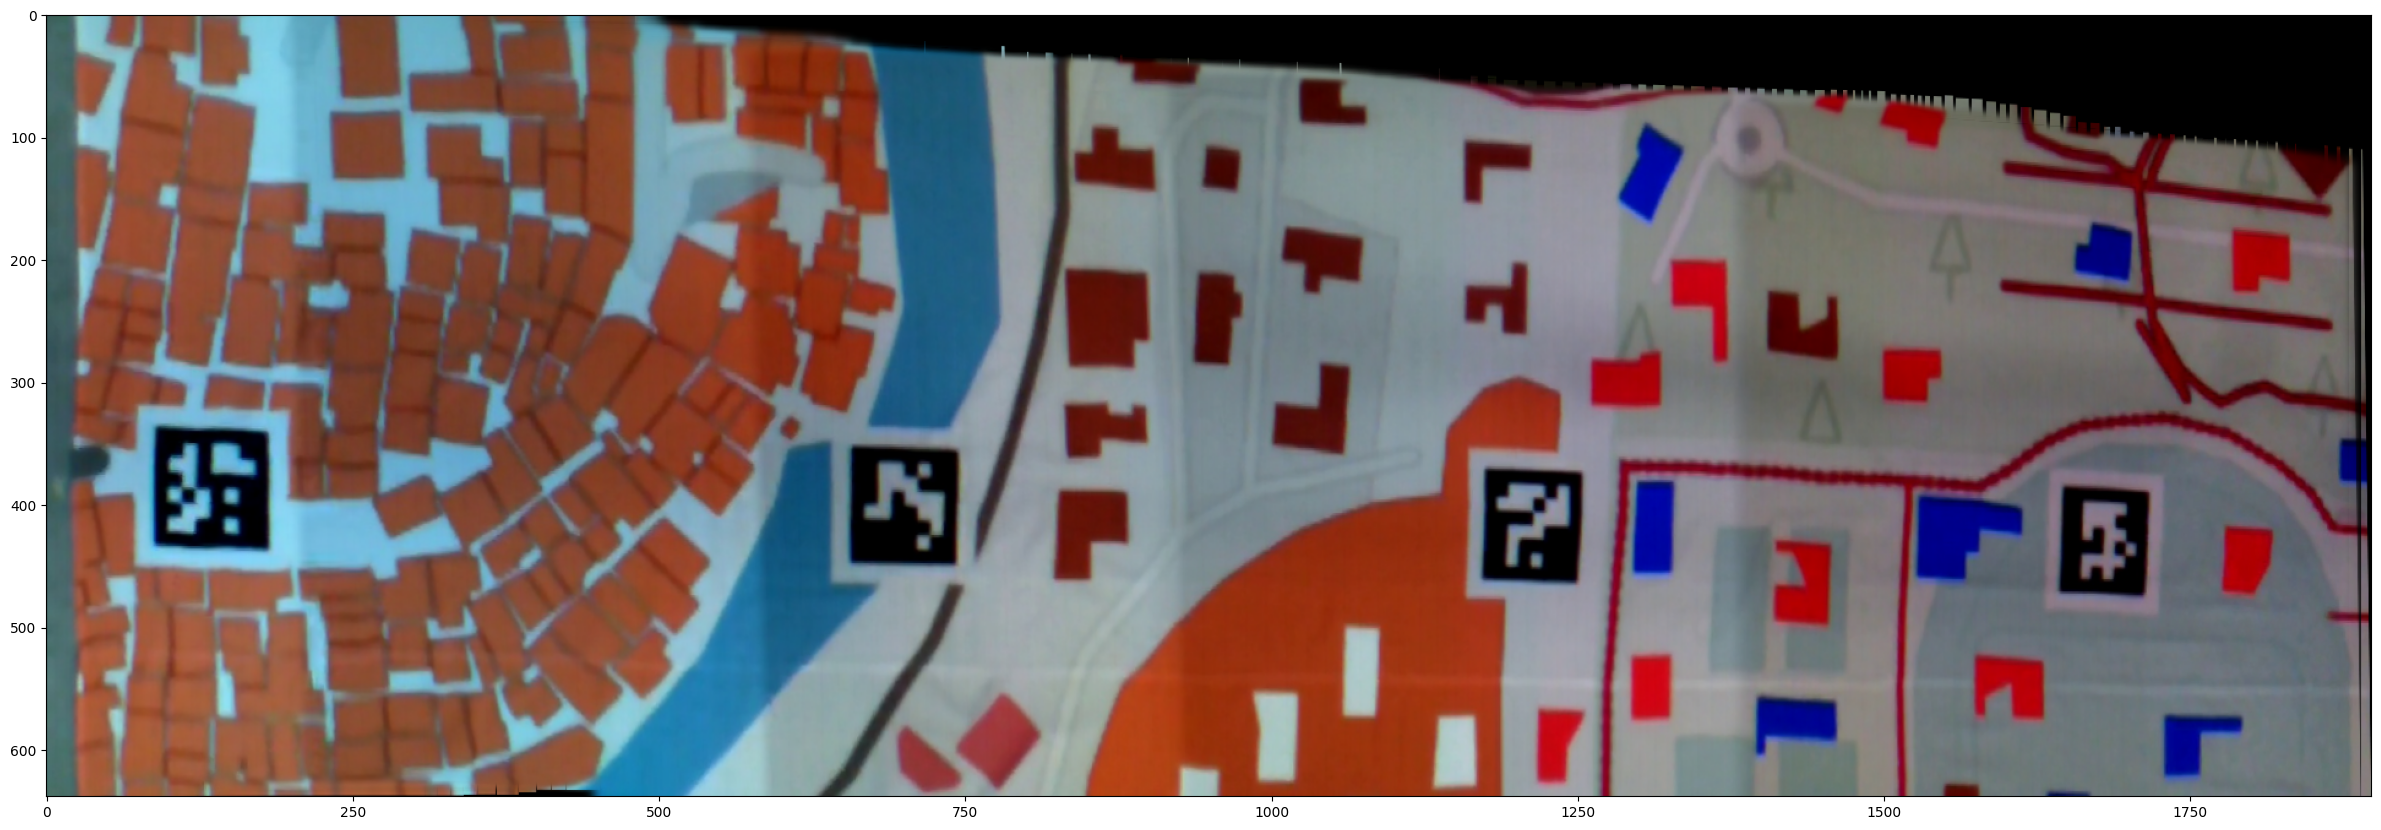

In [3]:
# ********* Versi 2 *********
# ********* Insert Image *********
image_paths = glob.glob('AmbilDataCahayaFullv2-04/*.jpg')
imgs = []
n = len(image_paths)
overlap = 0.9
dx = 100
dy = 30
# n = 2

# ********* Matriks Kalibrasi Kamera *********
mtx1 = np.array([[682.84055098,   0.,         308.47833431],
            [  0.,         683.17356074, 184.14295734],
            [  0.,           0.,           1.        ]
            ])
dist1 = np.array([-0.02243873,  0.10428033, -0.00261665, -0.00163101, -0.19535318])
newcameramtx1 = np.array([[680.79500661,   0.,         307.68874874],
            [  0.,         681.03835398, 183.55170193],
            [  0.,           0.,           1.        ]
            ])
roi1 = [1, 1, 638, 284]

# ********* Save Image in Var *********
for i in range(n):
    img = cv2.imread(image_paths[i])
    # Calibrating
    img = cv2.undistort(img, mtx1, dist1, None, newcameramtx1)
    x, y, w, h = roi1
    img = img[y:y+h, x:x+w]
    # Rotating
    # img = cv2.rotate(img, cv2.ROTATE_180)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    # Save image
    imgs.append(img)

# ********* Citra Kiri *********
pref = imgs[0]
pref_gray = cv2.cvtColor(pref, cv2.COLOR_BGR2GRAY)

# ********* Deklarasi Metode *********
orb = cv2.ORB_create(nfeatures=250, scaleFactor=1.2, nlevels=5, edgeThreshold=10, firstLevel=0, WTA_K=2, scoreType=1, patchSize=51, fastThreshold=20)

# ********* Mask *********
mask_top_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_left[:pref_gray.shape[0]//2+20, :pref_gray.shape[1]//2+20] = 255

mask_top_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_right[:pref_gray.shape[0]//2+20, pref_gray.shape[1]//2-20:] = 255

mask_bottom_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_left[pref_gray.shape[0]//2-20:, :pref_gray.shape[1]//2+20] = 255

mask_bottom_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_right[pref_gray.shape[0]//2-20:, pref_gray.shape[1]//2-20:] = 255

# ********* Ekstraksi Fitur Merah *********
kp_pref_tl, des_pref_tl = orb.detectAndCompute(pref[:,:,0], mask_top_left)
kp_pref_tr, des_pref_tr = orb.detectAndCompute(pref[:,:,0], mask_top_right)
kp_pref_bl, des_pref_bl = orb.detectAndCompute(pref[:,:,0], mask_bottom_left)
kp_pref_br, des_pref_br = orb.detectAndCompute(pref[:,:,0], mask_bottom_right)

kp_pref_R = kp_pref_tl + kp_pref_tr + kp_pref_bl + kp_pref_br
des_pref_R = np.vstack((des_pref_tl, des_pref_tr, des_pref_bl, des_pref_br))

# ********* Ekstraksi Fitur Hijau *********
kp_pref_tl, des_pref_tl = orb.detectAndCompute(pref[:,:,1], mask_top_left)
kp_pref_tr, des_pref_tr = orb.detectAndCompute(pref[:,:,1], mask_top_right)
kp_pref_bl, des_pref_bl = orb.detectAndCompute(pref[:,:,1], mask_bottom_left)
kp_pref_br, des_pref_br = orb.detectAndCompute(pref[:,:,1], mask_bottom_right)

kp_pref_G = kp_pref_tl + kp_pref_tr + kp_pref_bl + kp_pref_br
des_pref_G = np.vstack((des_pref_tl, des_pref_tr, des_pref_bl, des_pref_br))

# ********* Ekstraksi Fitur Biru *********
kp_pref_tl, des_pref_tl = orb.detectAndCompute(pref[:,:,2], mask_top_left)
kp_pref_tr, des_pref_tr = orb.detectAndCompute(pref[:,:,2], mask_top_right)
kp_pref_bl, des_pref_bl = orb.detectAndCompute(pref[:,:,2], mask_bottom_left)
kp_pref_br, des_pref_br = orb.detectAndCompute(pref[:,:,2], mask_bottom_right)

kp_pref_B = kp_pref_tl + kp_pref_tr + kp_pref_bl + kp_pref_br
des_pref_B = np.vstack((des_pref_tl, des_pref_tr, des_pref_bl, des_pref_br))

# # ********* Ekstraksi Fitur Gabungan *********
# kp_pref = kp_pref_R + kp_pref_G + kp_pref_B
# des_pref = np.vstack((des_pref_R, des_pref_G, des_pref_B))

# ********* Buang Fitur Berdempetan *********
kp_p_Rf, des_p_Rf = filter_fitur(kp_pref_R, des_pref_R)
kp_p_Gf, des_p_Gf = filter_fitur(kp_pref_G, des_pref_G)
kp_p_Bf, des_p_Bf = filter_fitur(kp_pref_B, des_pref_B)

# ********* Matriks Transformasi *********
TM = []

# ********* Loop Feature Detection - Get Transformation Matrix *********
for i in range(1,n):
    left = pref
    left_gray = pref_gray

    # kp_left = kp_pref
    # des_left = des_pref

    kp_l_Rf = kp_p_Rf
    des_l_Rf = des_p_Rf
    kp_l_Gf = kp_p_Gf
    des_l_Gf = des_p_Gf
    kp_l_Bf = kp_p_Bf
    des_l_Bf = des_p_Bf

    # ********* Citra Kanan *********
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

    # ********* Ekstraksi Fitur Merah *********
    kp_right_tl, des_right_tl = orb.detectAndCompute(right[:,:,0], mask_top_left)
    kp_right_tr, des_right_tr = orb.detectAndCompute(right[:,:,0], mask_top_right)
    kp_right_bl, des_right_bl = orb.detectAndCompute(right[:,:,0], mask_bottom_left)
    kp_right_br, des_right_br = orb.detectAndCompute(right[:,:,0], mask_bottom_right)
    
    kp_right_R = ()
    for var in [kp_right_tl, kp_right_tr, kp_right_bl, kp_right_br]:
        if var:
            kp_right_R += var
    des_right_R = np.array([])
    for var in [des_right_tl, des_right_tr, des_right_bl, des_right_br]:
        if var is not None:
            if des_right_R.size == 0:
                des_right_R = var
            else:
                des_right_R = np.vstack((des_right_R, var))
    
    # ********* Ekstraksi Fitur Hijau *********
    kp_right_tl, des_right_tl = orb.detectAndCompute(right[:,:,1], mask_top_left)
    kp_right_tr, des_right_tr = orb.detectAndCompute(right[:,:,1], mask_top_right)
    kp_right_bl, des_right_bl = orb.detectAndCompute(right[:,:,1], mask_bottom_left)
    kp_right_br, des_right_br = orb.detectAndCompute(right[:,:,1], mask_bottom_right)

    kp_right_G = ()
    for var in [kp_right_tl, kp_right_tr, kp_right_bl, kp_right_br]:
        if var:
            kp_right_G += var
    des_right_G = np.array([])
    for var in [des_right_tl, des_right_tr, des_right_bl, des_right_br]:
        if var is not None:
            if des_right_G.size == 0:
                des_right_G = var
            else:
                des_right_G = np.vstack((des_right_G, var))

    # ********* Ekstraksi Fitur Biru *********
    kp_right_tl, des_right_tl = orb.detectAndCompute(right[:,:,2], mask_top_left)
    kp_right_tr, des_right_tr = orb.detectAndCompute(right[:,:,2], mask_top_right)
    kp_right_bl, des_right_bl = orb.detectAndCompute(right[:,:,2], mask_bottom_left)
    kp_right_br, des_right_br = orb.detectAndCompute(right[:,:,2], mask_bottom_right)

    kp_right_B = ()
    for var in [kp_right_tl, kp_right_tr, kp_right_bl, kp_right_br]:
        if var:
            kp_right_B += var
    des_right_B = np.array([])
    for var in [des_right_tl, des_right_tr, des_right_bl, des_right_br]:
        if var is not None:
            if des_right_B.size == 0:
                des_right_B = var
            else:
                des_right_B = np.vstack((des_right_B, var))
    

    # # %%%%%%%%%% Gambar KeyPoint %%%%%%%%%%
    # kp_right = ()
    # for var in [kp_right_R, kp_right_G, kp_right_B]:
    #     if var:
    #         kp_right += var
    # des_right = np.array([])
    # for var in [des_right_R, des_right_G, des_right_B]:
    #     if var is not None:
    #         if des_right.size == 0:
    #             des_right = var
    #         else:
    #             des_right = np.vstack((des_right, var))
    # keypoints_drawn_left = cv2.drawKeypoints(left, kp_left, None, color=(0, 255, 0))
    # keypoints_drawn_right = cv2.drawKeypoints(right, kp_right, None, color=(0, 255, 0))
    # plot_images(keypoints_drawn_left, keypoints_drawn_right)

    # ********* Buang Fitur Berdempetan *********
    kp_r_Rf, des_r_Rf = filter_fitur(kp_right_R, des_right_R)
    kp_r_Gf, des_r_Gf = filter_fitur(kp_right_G, des_right_G)
    kp_r_Bf, des_r_Bf = filter_fitur(kp_right_B, des_right_B)
    
    # # %%%%%%%%%% Gambar Filtered KeyPoint %%%%%%%%%%
    # kp_l_f,_ = filter_fitur(kp_left, des_left)
    # kp_r_f,_ = filter_fitur(kp_right, des_right)

    # left_draw_kpR = pref.copy()
    # right_draw_kpR = imgs[i].copy()
    # for point in kp_l_Rf.astype(int):
    #     cv2.circle(left_draw_kpR, point, 4, (0,255,0))
    # for point in kp_r_Rf.astype(int):
    #     cv2.circle(right_draw_kpR, point, 4, (0,255,0))
    # # lr_draw_kp = cv2.addWeighted(left_draw_kp, 0.5, right_draw_kp, 0.5, 0)
    # plot_images(left_draw_kpR,right_draw_kpR)

    # left_draw_kpG = pref.copy()
    # right_draw_kpG = imgs[i].copy()
    # for point in kp_l_Gf.astype(int):
    #     cv2.circle(left_draw_kpG, point, 4, (0,255,0))
    # for point in kp_r_Gf.astype(int):
    #     cv2.circle(right_draw_kpG, point, 4, (0,255,0))
    # # lr_draw_kp = cv2.addWeighted(left_draw_kp, 0.5, right_draw_kp, 0.5, 0)
    # plot_images(left_draw_kpG,right_draw_kpG)
    
    # left_draw_kpB = pref.copy()
    # right_draw_kpB = imgs[i].copy()
    # for point in kp_l_Bf.astype(int):
    #     cv2.circle(left_draw_kpB, point, 4, (0,255,0))
    # for point in kp_r_Bf.astype(int):
    #     cv2.circle(right_draw_kpB, point, 4, (0,255,0))
    # # lr_draw_kp = cv2.addWeighted(left_draw_kp, 0.5, right_draw_kp, 0.5, 0)
    # plot_images(left_draw_kpB,right_draw_kpB)

    # ********* Pencocokan Fitur *********
    pt_mat_R = cocok_fitur(kp_l_Rf, des_l_Rf, kp_r_Rf, des_r_Rf, dx, dy, overlap)
    pt_mat_G = cocok_fitur(kp_l_Gf, des_l_Gf, kp_r_Gf, des_r_Gf, dx, dy, overlap)
    pt_mat_B = cocok_fitur(kp_l_Bf, des_l_Bf, kp_r_Bf, des_r_Bf, dx, dy, overlap)
    pt_mat = np.vstack((pt_mat_R, pt_mat_G, pt_mat_B))

    # # ********* Gambar Matches *********
    # img_con1 = np.concatenate((left, right), axis=1)
    # for x1, y1, x2, y2 in pt_mat_R.astype(int):
    #     cv2.line(img_con1, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con1, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con1, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con1)
    # img_con2 = np.concatenate((left, right), axis=1)
    # for x1, y1, x2, y2 in pt_mat_G.astype(int):
    #     cv2.line(img_con2, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con2, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con2, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con2)
    # img_con3 = np.concatenate((left, right), axis=1)
    # for x1, y1, x2, y2 in pt_mat_B.astype(int):
    #     cv2.line(img_con3, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con3, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con3, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con3)

    # ********* Cari Matriks Transformasi Terbaik *********
    iter=0
    Merr_v2=float('inf')
    while(True):
        iter+=1

        # ********* Mismatch Removal *********
        inliers = ransac(pt_mat, 40, 0.5, 2000)

        # ********* Image Registration *********
        right_pts = [(x,y) for _,_,x,y in inliers]
        left_pts = [(x,y) for x,y,_,_ in inliers]
        H, _ = cv2.findHomography(np.float32(right_pts), np.float32(left_pts))
        
        if type(H) != np.ndarray:
            continue

        # ********* Error MSE *********
        err = 0
        for xx1, yy1, xx2, yy2 in inliers:
            xe1, ye1,_ = H @ [xx2,yy2,1]
            Hinv = np.linalg.inv(H)
            xe2, ye2,_ = Hinv @ [xx1,yy1,1]
            err += (xx1 - xe1)**2 + (yy1 - ye1)**2 + (xx2 - xe2)**2 + (yy2 - ye2)**2
        err = err/len(inliers) 
         
        if err < Merr_v2:
            Merr_v2 = err
            M = H.copy()
            best_inliers = inliers.copy()
        if Merr_v2 < 3:
            print(str(i)+": "+str(Merr_v2))
            break
        elif iter > 50 and Merr_v2 < 20:
            print(str(i)+": "+str(Merr_v2))
            break
        elif iter > 100:
            break
        print(str(i)+": "+str(Merr_v2))
    print("===============================")

    # # %%%%%%%%%% Gambar Best Matches %%%%%%%%%%
    # img_con = np.ones((min(left.shape[0], right.shape[0]),left.shape[1] + right.shape[1],3), dtype="uint8")
    # img_con[0:img_con.shape[0],0:left.shape[1]] = left[0:img_con.shape[0],0:left.shape[1]]
    # img_con[0:img_con.shape[0],left.shape[1]:img_con.shape[1]] = right[0:img_con.shape[0],0:right.shape[1]]
    # for x1, y1, x2, y2 in best_inliers.astype(int):
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)

    # ********* Simpan Matriks Transformasi *********
    if i == 1:
        TM.append(M)
        TM = np.array(TM)
    else:
        Mbaru = TM[i-2] @ M.copy()
        TM = np.append(TM, [Mbaru], axis=0)

    # ********* Simpan Gambar Kanan Untuk Kiri *********
    pref = right
    pref_gray = right_gray

    # kp_pref = kp_right
    # des_pref = des_right

    kp_p_Rf = kp_r_Rf
    des_p_Rf = des_r_Rf
    kp_p_Gf = kp_r_Gf
    des_p_Gf = des_r_Gf
    kp_p_Bf = kp_r_Bf
    des_p_Bf = des_r_Bf
    
# ********* Loop Image Fussion *********
pref = imgs[0]
for i in range(1,n):
    left = pref
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)

    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    _, right_pp = cv2.threshold(right_pp, 1, 255, cv2.THRESH_BINARY)
    
    dim_x = left.shape[1] + right.shape[1]
    dim_y = max(left.shape[0], right.shape[0])
    dim = (dim_x, dim_y)

    comb = cv2.warpPerspective(right,TM[i-1],dim)
    comb_pp = cv2.warpPerspective(right_pp,TM[i-1],dim)

    # plot_images(comb)
    # canvas = np.zeros((dim_y, dim_x, left.shape[2]), dtype=np.uint8)
    # canvas[0:left.shape[0], 0:left.shape[1]] = left
    # plot_images(canvas)

    # ********* Membuat Mask *********
    kernel = np.ones((20, 20), np.uint8)
    mask = cv2.erode(comb_pp, kernel, iterations=1)
    mask = cv2.GaussianBlur(mask, (25, 25), 0)
    # plot_images(mask)

    # ********* Jahit Citra *********
    for k in range(left.shape[0]):
        for l in range(left.shape[1]):
            alpha = mask[k,l]/255
            comb[k,l] = (1-alpha)*left[k,l] + alpha*comb[k,l]
    # plot_images(comb)

    # ********* Crop *********
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]
plot_images(pref)
# cv2.imwrite("HasilAmbilDataCahayaFullv3-04v2.jpg", pref)